In [1]:
import datetime as dt
import itertools
import numpy as np
import pandas as pd
import os
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import holidays


from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from plotnine import *

In [2]:
# BASE_DIR = Path(__name__).resolve().parent.parent
FILES_DIR = '../files/'
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')
# log_df = pd.read_csv(FILES_DIR + 'log_csv.csv')

In [15]:
bidding = bidding_df.copy()

In [16]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [17]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
# Sum of AD rank = 반올림
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)

In [18]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null['CPC'].fillna(0, inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


In [19]:
bidding_drop_null["Year"] = bidding_drop_null.index.year 
bidding_drop_null["Quarter"] = bidding_drop_null.index.quarter
bidding_drop_null["Month"] = bidding_drop_null.index.month
bidding_drop_null["Week"] = bidding_drop_null.index.week
bidding_drop_null["Weekday"] = bidding_drop_null.index.weekday
bidding_drop_null["Day"] = bidding_drop_null.index.day
bidding_drop_null["Dayofyear"] = bidding_drop_null.index.dayofyear
bidding_drop_null["Date"] = pd.DatetimeIndex(bidding_drop_null.index).date

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\369508341.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [20]:
date_list = list(set(bidding_drop_null['Date']))
columns = ['ds', 'y']                 
bid_cost_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bidding_drop_null.loc[bidding_drop_null['Date'] == date]
    bid_cost_mean = bid_cost_mean.append(pd.DataFrame([[date, bid_mean['Click'].mean()]], columns=columns), ignore_index=True)
bid_cost_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\2444552252.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,ds,y
0,2022-11-29,115.563368
1,2023-01-03,150.507852
2,2022-11-14,262.176811
3,2022-11-25,179.631066
4,2022-11-27,265.413244
5,2022-10-31,274.325752
6,2022-11-02,158.357830
7,2022-11-23,248.469250
8,2022-11-01,224.028436
9,2022-12-03,118.732808


In [40]:
price_universe = pd.read_csv('price_universe.csv', index_col=0)
price_universe.index = pd.to_datetime(price_universe.index)

In [41]:
price_universe

,S&P 500,A,AAPL,ABC,ABT,ACGL,ADBE,ADI,ADM,ADP,...,SB,CC,KC,CT,LC,LH.1,FC,USDKRW,IEF,TLT
2018-01-02,2323.76,65.095131,40.950489,86.671799,53.904892,29.433332,177.699997,82.003815,34.854122,104.637054,...,18.76,2161.0,190.08,63.77,193.820,121.182,240.288,1061.20,96.978477,113.163429
2018-01-03,2339.29,66.751396,40.943363,86.994362,54.024086,29.459999,181.039993,83.021141,34.584610,105.773712,...,18.78,2130.0,188.00,64.18,194.250,122.113,240.206,1064.55,97.079865,113.704529
2018-01-04,2350.30,66.250656,41.133541,86.800812,53.932396,29.570000,183.220001,82.930305,35.167095,106.784096,...,18.72,2130.0,189.36,65.05,193.391,123.206,238.120,1062.15,97.033798,113.686455
2018-01-05,2366.48,67.309898,41.601864,87.851501,54.088268,29.453333,185.339996,83.266373,34.932358,106.720947,...,18.55,2119.0,187.71,64.17,188.744,123.165,232.272,1062.75,96.914001,113.361839
2018-01-08,2370.14,67.454338,41.447346,89.307693,53.932396,29.456667,185.039993,83.411736,34.854122,106.396202,...,18.25,2139.0,183.05,64.35,186.323,124.339,232.190,1066.10,96.867905,113.289734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,4801.71,156.562347,175.262802,127.924423,136.246506,43.480000,569.619995,169.451706,64.221039,237.479584,...,19.04,2591.0,219.98,86.08,156.671,70.424,193.477,1187.75,113.202599,145.104370
2021-12-27,4869.42,157.494995,179.289459,130.265030,138.498352,43.930000,577.679993,172.209473,64.839310,241.689438,...,19.06,2578.0,216.17,88.32,156.278,71.298,192.916,1186.80,113.241852,145.456100
2021-12-28,4865.61,157.931503,178.255417,130.719345,137.529083,44.270000,569.359985,171.139740,65.683281,241.473572,...,18.83,2603.0,214.79,86.88,156.418,71.156,195.220,1188.10,113.222221,144.879654
2021-12-29,4871.72,159.389984,178.344925,131.687180,138.233994,44.599998,569.289978,172.258560,65.761803,243.377304,...,18.98,2633.0,217.93,88.75,157.905,71.887,198.557,1186.40,112.643059,143.296921


In [44]:
sp500 = price_universe.iloc[:, :1].reset_index()

In [57]:
sp500.columns = ['ds', 'y']
sp500

,ds,y
0,2018-01-02,2323.76
1,2018-01-03,2339.29
2,2018-01-04,2350.30
3,2018-01-05,2366.48
4,2018-01-08,2370.14
...,...,...
951,2021-12-23,4801.71
952,2021-12-27,4869.42
953,2021-12-28,4865.61
954,2021-12-29,4871.72


In [86]:
class Prophet_model:

    def __init__(self, df: pd.DataFrame, param_grid: dict, matrics: str, periods=30, horizon='30 days'): 
        self.df = df
        self.df['y'] = df['y']
        self.df['ds'] = df['ds']
        self.param_grid = param_grid
        self.matrics = matrics
        self.periods = periods
        self.horizon = horizon

        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        evaluation_metrix = []  # Store the RMSEs for each params here
        
        holiday = pd.DataFrame([])
        for date, name in sorted(holidays.KR(years=[2018,2019,2020,2021]).items()):
            holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday' : "KR-Holidays"}, index=[0]), ignore_index=True)
        holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

        for params in all_params:
            model = Prophet(**params)
            model.fit(self.df)  # Fit model with given params
            df_cv = cross_validation(model, horizon=self.horizon, parallel="processes")
            df_p = performance_metrics(df_cv)
            evaluation_metrix.append(df_p[self.matrics].values[0])

        tuning_results = pd.DataFrame(all_params)
        tuning_results[self.matrics] = evaluation_metrix

        # Sorted by rmes values
        tuning_results = tuning_results.sort_values(by=[self.matrics])

        # Pick the optimized(having minimum rmse value) hyper-parameter combination
        self.final_params = tuning_results.iloc[0, :-1].to_dict()

        # Train the final model with optimized params
        self.m = Prophet(**self.final_params, holidays=holiday).fit(df)
        future = self.m.make_future_dataframe(periods=self.periods, freq='D')
        self.forecast = self.m.predict(future)

    def get_results(self):
        return self.m, self.final_params, self.forecast#.loc[self.df.shape[0]:, 'yhat'].values

In [80]:
param_grid = {
    'n_changepoints' : [25], 
    'growth' : ['linear'],
    'changepoint_range' : [0.8],
    'yearly_seasonality' : ['auto'],
    'weekly_seasonality' : ['auto'],
    'daily_seasonality' : ['auto'],
    'seasonality_mode' : ['additive'],
    'seasonality_prior_scale' : [5.0],
    'holidays_prior_scale' : [10],
    'changepoint_prior_scale' : [0.5], 
    'interval_width' : [0.8],
    'uncertainty_samples' : [1000]
                                                      
}

In [90]:
model = Prophet_model(sp500, param_grid=param_grid, matrics='mse', horizon='252 days')
model, final_params, forecast = model.get_results()

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

17:17:57 - cmdstanpy - INFO - Chain [1] done processing
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
17:18:05 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
params = []
model = Prophet_model(sp500, param_grid=param_grid, matrics='mse', horizon='30 days')
model, final_params, forecast = model.get_results()
params.append(final_params)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_7188\3227062285.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

15:29:52 - cmdstanpy - INFO - Chain [1] done processing
15:30:24 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:51 - cmdstanpy - INFO - Chain [1] start processing
15:31:51 - cmdstanpy - INFO - Chain [1] done processing
15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:51 - cmdstanpy - INFO - Chain [1] done processing
15:34:11 - cmdstanpy - INFO - Chain [1] start processing
15:34:12 - cmdstanpy - INFO - Chain [1] done processing
15:34:46 - cmdstanpy - INFO - Chain [1] start processing
15:34:47 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:36:10 - cmdstanpy - INFO - Chain [1] start processing
15:36:11 - cmdstanpy - INFO - Chain [1] done processing
15:37:10 - cmdstanpy - INFO - Chain [1] 

In [64]:
for param in params:
    print('changepoint_prior_scale : ', param['changepoint_prior_scale'])
    print('seasonality_prior_scale : ', param['seasonality_prior_scale'])
    print('seasonality_mode        : ', param['seasonality_mode'])
    print('holidays_prior_scale    : ', param['holidays_prior_scale'])
    print('n_changepoints          : ', param['n_changepoints'])
    

changepoint_prior_scale :  0.5
seasonality_prior_scale :  5.0
seasonality_mode        :  multiplicative
holidays_prior_scale    :  10
n_changepoints          :  25
seasonality_mode        :  multiplicative


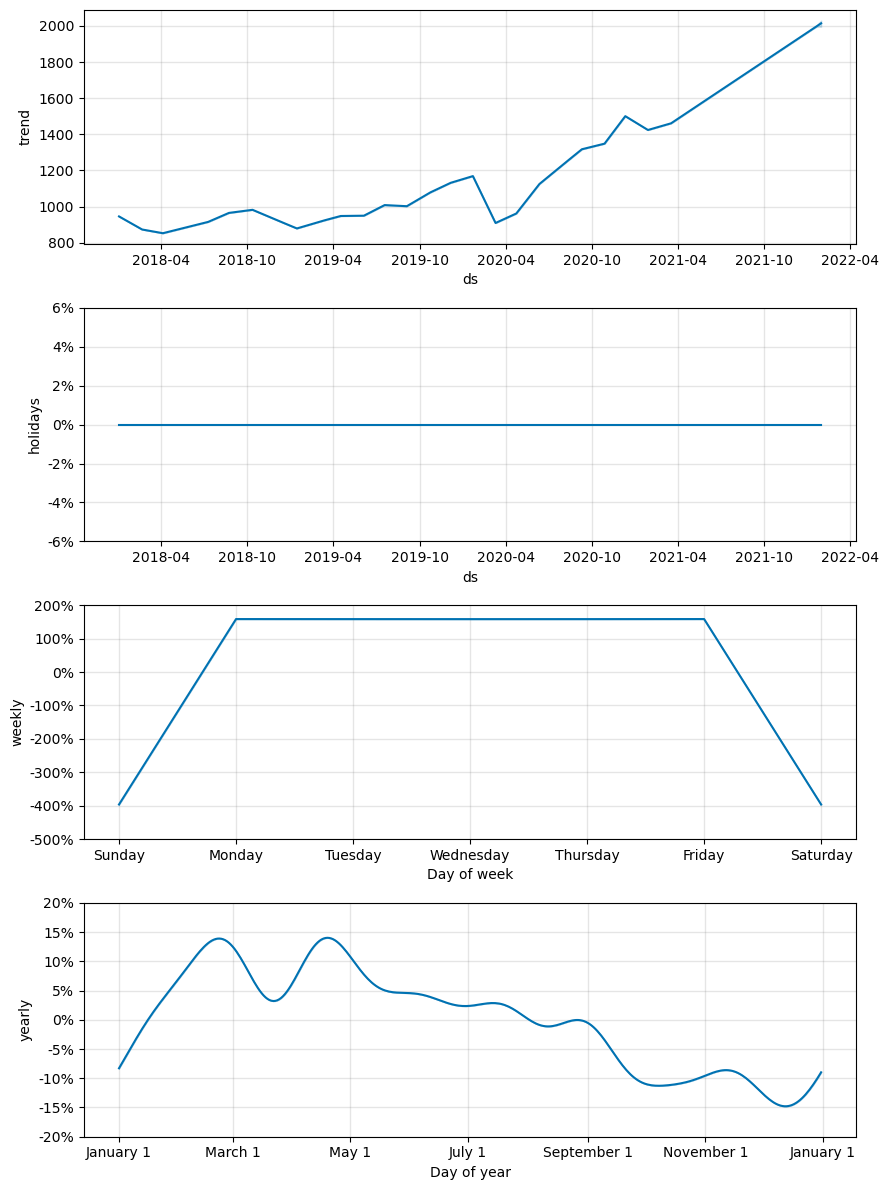

In [65]:
fig2 = model.plot_components(forecast)
plt.show()

In [91]:
# Python
plot_plotly(model, forecast)

Printing outputs from Prophet prediction...
             ds         yhat   yhat_lower   yhat_upper
0   2018-01-02  2354.132564  2278.573608  2426.986970
1   2018-01-03  2356.499704  2285.168676  2430.610478
2   2018-01-04  2360.302253  2285.605542  2432.062828
3   2018-01-05  2365.280297  2289.851292  2438.272601
4   2018-01-08  2373.718008  2299.837599  2443.575618
..         ...          ...          ...          ...
981 2022-01-25  5067.907833  4981.250249  5153.551918
982 2022-01-26  5073.294868  4986.233179  5166.694889
983 2022-01-27  5079.979744  4994.720507  5162.301653
984 2022-01-28  5087.772139  4999.868634  5182.489257
985 2022-01-29  4993.083581  4907.750462  5088.957280

[986 rows x 4 columns]


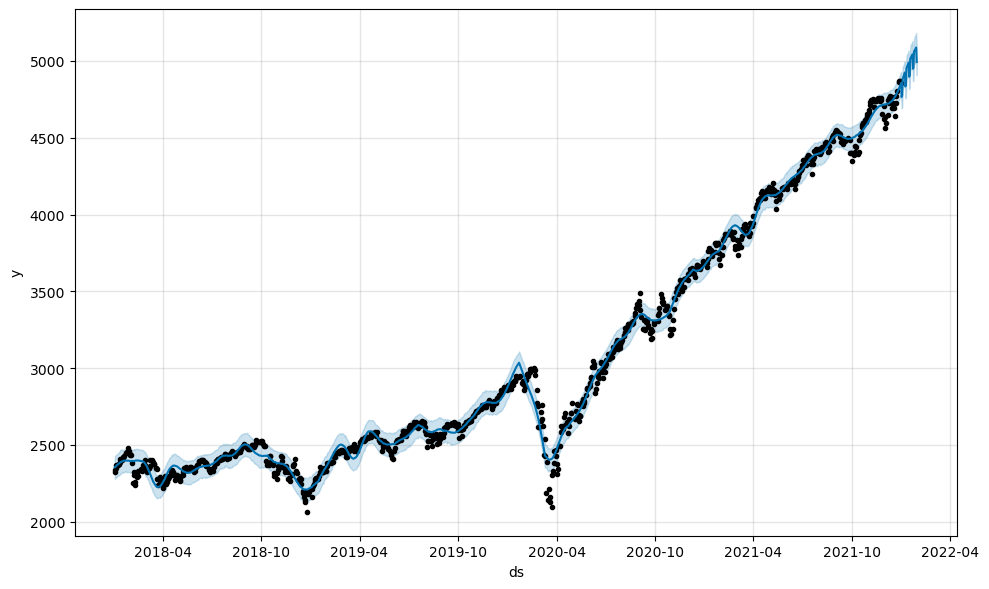

In [83]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# plot forecast
model.plot(forecast)
plt.show()